In [1]:
import pandas as pd             # data package
import matplotlib.pyplot as plt # graphics 
import datetime as dt
import numpy as np

# these are new 
import requests, io             # internet and input tools  
import zipfile as zf            # zip file tools 
import shutil                   # file management tools 
import os                       # operating system tools (check files)

from census import Census # This is new...

import geopandas as gpd # this is the main geopandas 
from shapely.geometry import Point, Polygon # also needed

import pyarrow as pa
import pyarrow.parquet as pq

##########################
# Then this stuff below allows us to make a nice inset


from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

### Overview of code

Thansk to the [@nytimes](https://github.com/nytimes/covid-19-data). This proved to be very easy given my existing code associated with my project on the [trade war](https://github.com/mwaugh0328/consumption_and_tradewar). The code proceeds in several steps:

1. Grabs the nytimes data. Their repository provides detailed explanations regarding geography etc. NYC in particular is treated as one region, not by county. 


2. Download shapefiles from the US census. This only needs to be done once. 


3. Merge nytimes data with the geopandas dataframe, add in US Census data (currently just population), then some simple cleaning to prepare for maping.


4. Create a static map using geopandas. This will generate a ``.png`` file. If you wanted to create a movie. You could do this for everydate and then piece the ``.png`` files together to create one.


5. Create a live/html map with hover tool and zoom using Bokeh's packages. The output will be an .html file with can be posted on a website etc. It is currently posted at [https://mwaugh0328.github.io/covid-19-map/us_covid_map.html](https://mwaugh0328.github.io/covid-19-map/us_covid_map.html)

---

### Step \#1. Grab data from [nytimes repository](https://github.com/nytimes/covid-19-data)

Thank you for organizing this. It's very simple...

In [2]:
df = pd.read_csv("https://github.com/nytimes/covid-19-data/raw/master/us-counties.csv")

In [3]:
# For NYC we will assing it the Mannhatten fips code
# Then below to the other new york city counties we 
# assing them the same case and death data as New York city as a whole

nyc = df.county == "New York City"
df.loc[nyc,"fips"] = 36061

In [4]:
# Convert the date to a datetime object
df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

In [5]:
latest_date = df.date.max()

In [6]:
latest_date = latest_date.strftime("%m/%d/%Y")

In [7]:
df.set_index("date", inplace = True)

In [8]:
dfall = df.loc[latest_date].copy()

**Important data note** The nytimes dataset reports **cumulative** cases, not the number reported each day. The very first version of this code messed this up. Now it is correct.

In [9]:
dfall[dfall.county == "New York City"]

,county,state,fips,cases,deaths
date,,,,,
2020-04-16,New York City,New York,36061.0,123146,8632


In [10]:
total = dfall.cases.sum()

print("Total US Covid-19 Cases", total, "as of", latest_date)

Total US Covid-19 Cases 667929 as of 04/16/2020


In [11]:
total_deaths = dfall.deaths.sum()

print("Total US Covid-19 Deaths", total_deaths, "as of", latest_date)

Total US Covid-19 Deaths 30773 as of 04/16/2020


In [12]:
dfall[dfall["fips"] == 36061]

,county,state,fips,cases,deaths
date,,,,,
2020-04-15,New York City,New York,36061.0,118302,8215


In [13]:
#dfall.reset_index(inplace = True)

#indexnyc = dfall[dfall['county'] == "New York"].index
 
# Delete these row indexes from dataFrame
#dfall.drop(indexnyc, inplace=True)

#dfall.set_index(["date"], inplace = True)

---

###  Step \#2. Get US County and State, Shapefiles

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [12]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

cwd = os.getcwd()

county_url = "https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip"
    
r = requests.get(county_url ) 

county_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

county_shapefile.extractall(path = cwd + "\\shapefiles\\county")

del r, county_shapefile


**********************************************************************************



In [13]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

state_url = "https://www2.census.gov/geo/tiger/TIGER2017/STATE/tl_2017_us_state.zip"
    
r = requests.get(state_url) 

state_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

state_shapefile.extractall(path = cwd + "\\shapefiles\\state")

del r, state_shapefile


**********************************************************************************



This will fix the great lakes issue. I found a shapefile with lakes of the world

In [15]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

cwd = os.getcwd()

county_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_lakes.zip"
    
r = requests.get(county_url ) 

lake_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

lake_shapefile.extractall(path = cwd + "\\shapefiles\\lake")

del r, lake_shapefile


**********************************************************************************



In [81]:
print("")
print("**********************************************************************************")
print("Downloading Shape files")
print("")

cwd = os.getcwd()

county_url = "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/physical/ne_50m_land.zip"
    
r = requests.get(county_url ) 

land_shapefile = zf.ZipFile(io.BytesIO(r.content)) 

land_shapefile.extractall(path = cwd + "\\shapefiles\\land")

del r, land_shapefile


**********************************************************************************



In [12]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\lake\\ne_10m_lakes.shx"

lake_map = gpd.read_file(county_shape)

lake_map = lake_map.to_crs({'init': 'epsg:3395'})

In [13]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\land\\ne_50m_land.shx"

land_map = gpd.read_file(county_shape)

land_map = land_map.to_crs({'init': 'epsg:3395'})

land_map = land_map.iloc[0:1200]

In [14]:
cwd = os.getcwd()

county_shape = cwd + "\\shapefiles\\county\\tl_2017_us_county.shx"

us_map = gpd.read_file(county_shape)

us_map = us_map.to_crs({'init': 'epsg:3395'})

In [15]:
us_map["geometry"] = us_map["geometry"].simplify(200)
# This was important. The geometry in the tigerline file si
# too fine, orginal map was 350mb. simply basicly simplifies the geometry,
# making the map take up less memory and load faster. Still not sure
# what the number exactly means.

In [16]:
us_map["area_fips"] = (us_map.STATEFP.astype(str) + us_map.COUNTYFP.astype(str)).astype(int)

---

###  Step \#3 Merge and Clean

The next couple of cells download the requisite shapefiles from the US census. They are unzipped in a folder called shapefiles and then county. So they are assuming some structure behind your folder setup. 

In [17]:
us_map = us_map.merge(dfall, left_on='area_fips',
                      right_on = "fips", how = "left", indicator = True)

The cell below fills in the NYC region with the NYC values. So in the hover map, when you hover over say Brookly, it will show the value for the NYC region. I then added a data note column that will inform the reader of this.

In [18]:
#Fill in Queens (36081), Bronx (36005, Richmond(36085), Brooklyn (36047)
nyc_counties = [36081,36005,36085,36047]

us_map.loc[us_map.area_fips.isin(nyc_counties), "deaths"] = us_map.loc[us_map.area_fips == 36061,"deaths"].values[0]

us_map.loc[us_map.area_fips.isin(nyc_counties), "cases"] = us_map.loc[us_map.area_fips == 36061,"cases"].values[0]

us_map["Notes"] = ""

all_nyc_counties = [36081,36005,36085,36047,36061]

us_map.loc[us_map.area_fips.isin(all_nyc_counties), "Notes"] = "NYC counties are treated as one region"

In [19]:
all_nyc_counties = [36081,36005,36085,36047,36061]

us_map.loc[us_map.area_fips.isin(all_nyc_counties)]

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,INTPTLON,geometry,area_fips,county,state,fips,cases,deaths,_merge,Notes
1399,36,085,00974141,36085,Richmond,Richmond County,06,H6,G4020,408,...,-074.1398995,POLYGON ((-8266483.974252383 4911049.094469544...,36085,NaN,NaN,NaN,123146.0,8632.0,left_only,NYC counties are treated as one region
2333,36,081,00974139,36081,Queens,Queens County,06,H6,G4020,408,...,-073.8380168,POLYGON ((-8241887.042205681 4916699.001055642...,36081,NaN,NaN,NaN,123146.0,8632.0,left_only,NYC counties are treated as one region
2409,36,047,00974122,36047,Kings,Kings County,06,H6,G4020,408,...,-073.9506398,POLYGON ((-8243928.307708359 4930339.699908601...,36047,NaN,NaN,NaN,123146.0,8632.0,left_only,NYC counties are treated as one region
2446,36,061,00974129,36061,New York,New York County,06,H6,G4020,408,...,-073.9701871,(POLYGON ((-8242889.140261804 4938939.08757678...,36061,New York City,New York,36061.0,123146.0,8632.0,both,NYC counties are treated as one region
3162,36,005,00974101,36005,Bronx,Bronx County,06,H6,G4020,408,...,-073.8529390,POLYGON ((-8230256.493127092 4967047.620882855...,36005,NaN,NaN,NaN,123146.0,8632.0,left_only,NYC counties are treated as one region


In [20]:
#us_map[["NAME","NAMELSAD","county","state", "cases"]].head(48)

I'm from Alaska, so this next step is always painfull. Drop states and territories who are not part of the "lower 48", contiguous US. Still not clear how fix this in geopandas.

In [21]:
us_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

us_map.drop(drop_list, inplace = True)

In [22]:
state_shape = cwd + "\\shapefiles\\state\\tl_2017_us_state.shx"

state_map = gpd.read_file(state_shape)

state_map = state_map.to_crs({'init': 'epsg:3395'})

state_map["geometry"] = state_map["geometry"].simplify(200)

In [23]:
state_fp_dict = dict(zip(state_map.STATEFP, state_map.STUSPS))

In [24]:
state_map.set_index("STATEFP", inplace = True)

drop_list = ["02","15","72","78","69","66","60",]

state_map.drop(drop_list, inplace = True)

In [25]:
us_map.reset_index(inplace = True)

In [26]:
us_map["STSPS"] = us_map["STATEFP"].map(state_fp_dict)

In [27]:
us_map["NAME"] = us_map["NAME"] + ", " + us_map["STSPS"]

In [28]:
us_map.set_index("STATEFP", inplace = True)

In [29]:
#us_map["cases"].replace("nan", np.nan, inplace = True)

#us_map["cases"] = us_map["cases"].str.replace(',','')

#us_map["cases"] = us_map["cases"].astype(int)

us_map["cases_label"] = us_map["cases"].round(0)

us_map["cases_label"] = us_map["cases_label"].map('{:,.0f}'.format)

us_map["deaths_label"] = us_map["deaths"].round(0)

us_map["deaths_label"] = us_map["deaths_label"].map('{:,.0f}'.format)

#### Add Census Data

Here I add this in. MY api key is posted here, please be respectfull of it.

In [30]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7'
# This is my api_key, # don't abuse this.

c = Census(my_api_key)
# This will create an object c which has methods associated with it.
# We will see  these below.

code = ("NAME","B01001_001E") 
# Get more stuff from the cencuss if we want...

county_2017 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'county:*'}, year=2017))
                                         # Same deal, but we specify county then the wild card
                                         # On the example page, there are ways do do this, only by state
        
county_2017 = county_2017.rename(columns = {"B01001_001E":"2017_population"})

county_2017["GEOFIPS"] = (county_2017["state"] + county_2017["county"]).astype(int)

county_2017["2017_population"] = county_2017["2017_population"].astype(float)

county_2017.set_index(["GEOFIPS"], inplace = True)

In [31]:
county_2017.head()

,NAME,2017_population,state,county
GEOFIPS,,,,
72047,"Corozal Municipio, Puerto Rico",34933.0,72,047
72095,"Maunabo Municipio, Puerto Rico",11297.0,72,095
72111,"Peñuelas Municipio, Puerto Rico",21661.0,72,111
72113,"Ponce Municipio, Puerto Rico",148863.0,72,113
72131,"San Sebastián Municipio, Puerto Rico",38970.0,72,131


In [32]:
us_map = us_map.merge(county_2017[["2017_population"]], 
                      left_on='area_fips', right_on = "GEOFIPS", how = "left")

In [33]:
us_map["pop_label"] = us_map["2017_population"].map('{:,.0f}'.format)

In [34]:
q_cases = [0,1,5,10,100,250,500,1000,5000,10000,np.inf]

In [35]:
us_map["q_cases"]= pd.cut(us_map["cases"],q_cases, labels=range(0,10))
us_map["q_deaths"]= pd.cut(us_map["deaths"],q_cases, labels=range(0,10))

In [36]:
us_map["q_deaths"].max()

8

In [37]:
us_map["cases_label"].replace("nan", "None reported", inplace = True)
us_map["deaths_label"].replace("nan", "None reported", inplace = True)

The final issue is to create the borders associated with the great lakes. The issue is that the tigerline shape files just extend boundries into the waterline. And the associated coastline maps are (i) not polygons and (ii) looked messed up. So per above, I found another shape file of lakes. Then I will use geopandas built in set operations to essentially "punch out" the holes associated with the great lakes. 

[https://geopandas.org/set_operations.html](https://geopandas.org/set_operations.html)

**Note** for teaching purposes, it's worth messing around with the ``how`` operations to understand what is going on here.

In [38]:
# This operation will take care of the coastline

us_map = gpd.overlay(us_map, land_map,  how='intersection')

In [39]:
great_lakes = ["Lake Superior", "Lake Michigan", "Lake Erie","Lake Superior""Lake Huron"]

us_map = gpd.overlay(us_map, lake_map[lake_map.name.isin(great_lakes)],  how='difference')
# this is the key operation...note that the order matters on the difference operation. output is same 

In [40]:
state_map = gpd.overlay(state_map, land_map,  how='intersection')

state_map = gpd.overlay(state_map, lake_map[lake_map.name.isin(great_lakes)],  how='difference')
# Do the same thing for the state map

---

### Step \# 4. Create a Static map

Below is a set of code and lots of tricks to make a nice looking static map using Geopandas build in functionality. The output file is a ``.png`` file. Should enhance this by adding the date and generating the maps by date.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


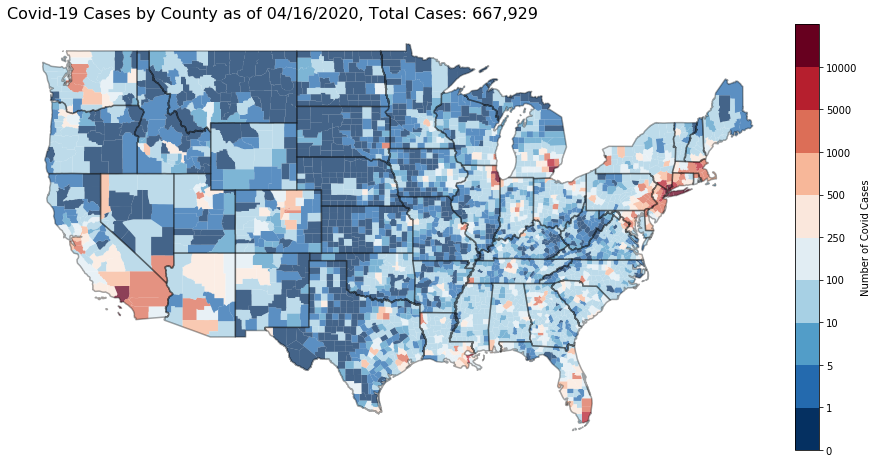

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1,1,figsize = (12,8))

plt.tight_layout()
plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

#################################################################################
# This is for the colorbar...

divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="3%", pad=0.1)

#################################################################################
## This creates a discrete colorbar scheme...
# https://gist.github.com/jakevdp/91077b0cae40f8f8244a

N = 10

base = plt.cm.get_cmap("RdBu_r")

color_list = base(np.linspace(0, 1, N))

cmap_name = base.name + str(N)

dcmap =  base.from_list(cmap_name, color_list, N)

#################################################################################
# This is the normal mapping...

#us_map[us_map.q_cases.isna()].plot(alpha = 0.25, color = "grey", ax = ax,)

us_map.plot(column='q_cases', ax = ax,
              # THIS IS NEW, it says color it based on this column
             cmap=dcmap, 
             alpha = 0.75,
             vmin=0, vmax=us_map.q_cases.max())

#################################################################################
# This then alows me to generate and edit the colorbar....
# https://stackoverflow.com/questions/53158096/editing-colorbar-legend-in-geopandas

sm = plt.cm.ScalarMappable(cmap=dcmap)
sm._A = []
cbr = fig.colorbar(sm, cax=cax)

cbr.set_label('Number of Covid Cases')
cbr.set_alpha(0.15)

cbr.set_ticks([0, 0.10, 0.20, 0.30,0.40,0.50,0.60,0.70,0.80, 0.90])
cbr.set_ticklabels(q_cases, update_ticks=True)

#################################################################################

state_map.geometry.boundary.plot(color=None, edgecolor='k', alpha = 0.35, ax = ax)

#coast_map.plot(color='k', edgecolor='k', alpha = 0.25, ax = ax)

#################################################################################
# Then some final stuff to clean things up....

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

title = "Covid-19 Cases by County as of " + latest_date + ", Total Cases: " + f"{total:,d}"
title_death = "Covid-19 Deaths by County as of " + latest_date + ", Total Deaths: " + f"{total_deaths:,d}"
ax.set_title(title, fontsize = 16, loc= "left" )

plt.savefig("covid-19-map.png", bbox_inches = "tight", dip = 1200)

plt.show()

---

### Step \# 5. Create Live/html map

This took a huge amount of effort to all sort out form bokeh's documentation and other resources. It works and generates something really great in my opinion. 

Note, need to have a folder called ``docs`` below the working directory. It will save the ``.html`` file there. Then to see the map, just open the ``.html`` file in a web browswer.

**Updated** the code was modified to create ``tabs`` where the user could [select the measure](https://docs.bokeh.org/en/latest/docs/user_guide/interaction/widgets.html). In this case it will creat two tabs one for cases, one for deaths. This is very simple. Just great two mapping objects and then combine them using this ``tab`` function.

In [42]:
import json
from bokeh.io import show
from bokeh.models import (CDSView, ColorBar, ColumnDataSource,
                          CustomJS, CustomJSFilter, 
                          GeoJSONDataSource, HoverTool,
                          LinearColorMapper, Slider)
from bokeh.layouts import column, row, widgetbox
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.models import Title

from bokeh.plotting import figure, save

from bokeh.models import Panel, Tabs

from bokeh.resources import CDN
from bokeh.embed import file_html

# Input GeoJSON source that contains features for plotting
#geosource = GeoJSONDataSource(geojson = us_map.to_json())

This is cell containst stuff that is common across the two plots

In [43]:
state_geosource = GeoJSONDataSource(geojson = state_map.to_json())

#coast_geosource = GeoJSONDataSource(geojson = coast_map.to_json())

geosource = GeoJSONDataSource(geojson = us_map.to_json())

palette = brewer['RdBu'][10]

#https://docs.bokeh.org/en/latest/docs/reference/palettes.html

color_mapper = LinearColorMapper(palette = palette, low = 0, high = 9)

tick_labels = {2:str(q_cases[2]), 
              4:str(q_cases[4]), 6:str(q_cases[6]), 8 :str(q_cases[9])}

This cell contains the first "tab" which is number of cases

In [44]:
color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 20, height = 420,
                     border_line_color = None,
                     orientation = "vertical",
                     location=(0,0), major_label_overrides = tick_labels,
                     major_tick_line_alpha = .25)

# Create figure object.
p = figure( 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "box_zoom, reset")

descip = "Colorbar by # of covid-19 cases; Hover tool reports county name, cases, deaths, and data notes."
descip = descip + "Data from https://github.com/nytimes/covid-19-data"
p.add_layout(Title(text=descip, text_font_style="italic", text_font_size="9pt"), 'above')
p.add_layout(Title(text=title, text_font_size="11pt"), 'above')

author = "Created by Michael Waugh, NYU-Stern and NBER, www.waugheconomics.com"
p.add_layout(Title(text=author, text_font_style="italic", text_font_size="9pt"), 'below')


p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# Add patch renderer to figure.

states = p.patches('xs','ys', source = geosource,
                   fill_color = {"field" :'q_cases',
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)

state_line = p.multi_line('xs','ys', source = state_geosource,
                   line_color = "black", 
                   line_width = 0.5)

#coast_line = p.multi_line('xs','ys', source = coast_geosource,
#                   line_color = "black", 
#                   line_width = 0.5)
# Create hover tool

p.add_tools(HoverTool(renderers = [states],
                      tooltips = [('County','@NAME'),
                                ('Cases','@cases_label'),
                                 ('Deaths','@deaths_label'),
                                ('Population (2017)','@pop_label'),
                                 ('Data Notes','@Notes')]))

#### Some features to make it a bit nicer. 

p.axis.visible = False
p.background_fill_color = "grey"
p.background_fill_alpha = 0.25

p.toolbar.autohide = True

p.add_layout(color_bar, "right")

## Send to doc file, create a webpage from doc file on github
# then had weebly webiste point to that .html file. That's how
# I got this to work.

This then creates the second tab which is deaths

In [45]:
tick_labels = {2:str(q_cases[2]), 
              4:str(q_cases[4]), 6:str(q_cases[6]), 8 :str(q_cases[9])}

color_bar = ColorBar(color_mapper = color_mapper, 
                     label_standoff = 8,
                     width = 20, height = 420,
                     border_line_color = None,
                     orientation = "vertical",
                     location=(0,0), major_label_overrides = tick_labels,
                     major_tick_line_alpha = .25)

label = 'Percentile in Distribution of Covid Cases'
# Create figure object.
pdth = figure( 
           plot_height = 600 ,
           plot_width = 950, 
           toolbar_location = 'below',
           tools = "box_zoom, reset")

descip = "Colorbar by # of covid-19 deaths; Hover tool reports county name, cases, deaths, and data notes."
descip = descip + " Data from https://github.com/nytimes/covid-19-data"
pdth.add_layout(Title(text=descip, text_font_style="italic", text_font_size="9pt"), 'above')
pdth.add_layout(Title(text=title_death, text_font_size="11pt"), 'above')

author = "Created by Michael Waugh, NYU-Stern and NBER, www.waugheconomics.com"
pdth.add_layout(Title(text=author, text_font_style="italic", text_font_size="9pt"), 'below')


pdth.xgrid.grid_line_color = None
pdth.ygrid.grid_line_color = None
# Add patch renderer to figure.

states = pdth.patches('xs','ys', source = geosource,
                   fill_color = {"field" :'q_deaths',
                                 "transform" : color_mapper},
                   line_color = "gray", 
                   line_width = 0.25, 
                   fill_alpha = 1)

state_line = pdth.multi_line('xs','ys', source = state_geosource,
                   line_color = "black", 
                   line_width = 0.5)

#coast_line = p.multi_line('xs','ys', source = coast_geosource,
#                   line_color = "black", 
#                   line_width = 0.5)
# Create hover tool

pdth.add_tools(HoverTool(renderers = [states],
                      tooltips = [('County','@NAME'),
                                ('Cases','@cases_label'),
                                 ('Deaths','@deaths_label'),
                                ('Population (2017)','@pop_label'),
                                 ('Data Notes','@Notes')]))

#### Some features to make it a bit nicer. 

pdth.axis.visible = False
pdth.background_fill_color = "grey"
pdth.background_fill_alpha = 0.25

pdth.toolbar.autohide = True

pdth.add_layout(color_bar, "right")

## Send to doc file, create a webpage from doc file on github
# then had weebly webiste point to that .html file. That's how
# I got this to work.

Then this combines it using the tab operation.

In [46]:
tab1 = Panel(child=p, title="Cases")
tab2 = Panel(child=pdth, title="Deaths")

tabs = Tabs(tabs=[ tab1, tab2 ])

file_path = os.getcwd()

doc_path = file_path +"\\docs"

outfp = doc_path + "\\us_covid_map.html"

# Save the map
save(tabs, outfp)

# Not sure if this is important, but seemed to start working once
# I ran it
html = file_html(tabs, CDN, outfp)

C:\ProgramData\Anaconda3\lib\site-packages\bokeh\io\saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
C:\ProgramData\Anaconda3\lib\site-packages\bokeh\io\saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")
